# GOES Satellite data



In [1]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

from datetime import datetime, timedelta
from netCDF4 import Dataset

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob

import numpy as np
import os

In [67]:
#set time to plot
realtime = False
archive = True

year   = 2019
month  = 4
day    = 2
hour   = 21
minute = 0
    
#set plot domain
lat_min = 25
lat_max = 45
lon_min = -90
lon_max = -65

goes_16 = True
goes_17 = False
goes_18 = False


#ABI-L1b-RadC #CONUS
#ABI-L1b-RadF #Full Disk
#ABI-L1b-RadM #Mesoscale
prod = 'ABI-L1b-RadC'
channel = 8
              
channel = '%02i'%channel

if archive:
    dt = datetime(year,month,day,hour,minute)
elif realtime:
    dt = datetime.utcnow()

## Connect to NOAA's GOES 16 S3 Bucket on AWS and Download Matching File

In [68]:
noaa_bucket = ''
if goes_16:
    noaa_bucket = 'noaa-goes16'
    string = 'GOES-16 (EAST)'
    lon = -75.2
elif goes_17:
    noaa_bucket = 'noaa-goes17'
    string = 'GOES-17 (WEST)'
    lon = -137.2
elif goes_18:
    noaa_bucket = 'noaa-goes18'
    string = 'GOES-18 (WEST)'
    lon = -137.0
else:
    print('error')

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket(noaa_bucket)
#product/YYYY/JJJ/HH/OR_prod-M[3 or 6]C##_sYYYYJJJHHMMSSS_e..._c....nc

path = f'{prod}/{dt:%Y}/{dt:%j}/{dt:%H}/OR_{prod}-M6C{channel}_'
objs = bucket.objects.filter(Prefix=path)
files = np.array([i.key for i in objs])

if len(files) == 0:
    path = f'{prod}/{dt:%Y}/{dt:%j}/{dt:%H}/OR_{prod}-M3C{channel}_'
    objs = bucket.objects.filter(Prefix=path)
    files = np.array([i.key for i in objs])
    
if len(files) == 0:
    print("No Data for this day")
    if goes_16:
        print("GOES 16 became operational on 28 February 2017")
        print("Current date is %s"%datetime.utcnow().strftime('%d %B %Y'))
        print("Requested date is %s"%dt.strftime('%d %B %Y'))
    elif goes_17:
        print("GOES 17 became operational on 28 August 2017")
        print("GOES 18 became the operational GOES-West on 28 July 2022")
        print("Current date is %s"%datetime.utcnow().strftime('%d %B %Y'))
        print("Requested date is %s"%dt.strftime('%d %B %Y'))
        if dt>datetime.strptime('28-07-2022','%d-%m-%Y'):
            print("Please use GOES 18")
    elif goes_18:
        print("GOES 18 became operational on 28 July 2022")
        print("Prior to this date, GOES 17 was the operational GOES-West")
        print("Current date is %s"%datetime.utcnow().strftime('%d %B %Y'))
        print("Requested date is %s"%dt.strftime('%d %B %Y'))
    import sys
    sys.exit()

start_times = np.array([datetime.strptime(i[52:65],'%Y%j%H%M%S') for i in files])
#end_times = np.array([datetime.strptime(i[68:81],'%Y%j%H%M%S') for i in files])
print(files)
delta_t = np.array([abs((dt - i)).seconds for i in start_times])
file = files[np.argmin(delta_t)]

if os.path.exists("tmp.nc"):
    os.remove("tmp.nc")

    
print(file)
s3_client.download_file(noaa_bucket, file, 'tmp.nc')


['ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s20190922101191_e20190922103564_c20190922104015.nc'
 'ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s20190922106191_e20190922108564_c20190922109004.nc'
 'ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s20190922111191_e20190922113564_c20190922114007.nc'
 'ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s20190922116191_e20190922118564_c20190922119006.nc'
 'ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s20190922121191_e20190922123564_c20190922124013.nc'
 'ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s20190922126191_e20190922128564_c20190922129005.nc'
 'ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s20190922131191_e20190922133564_c20190922134014.nc'
 'ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s20190922136191_e20190922138564_c20190922139005.nc'
 'ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s20190922141191_e20190922143564_c20190922144006.nc'
 'ABI-L1b-RadC/2019/092/21/OR_ABI-L1b-RadC-M6C08_G16_s2

## Read Data, Subset, and Plot

In [69]:
goes = Dataset('tmp.nc','r')

wl = goes.variables['band_wavelength'][:]
t = float(goes.variables['t'][:])

img_time = datetime(2000,1,1,12,0)+timedelta(seconds=t)

rad = goes.variables['Rad'][:]
if int(channel) <= 6:
    rad = rad/np.nanmax(rad)
elif int(channel) > 6:
    fk1 = goes.variables['planck_fk1'][:]
    fk2 = goes.variables['planck_fk2'][:]
    bc1 = goes.variables['planck_bc1'][:]
    bc2 = goes.variables['planck_bc2'][:]
    rad = ( fk2 / ( np.log(( fk1 / rad ) + 1 )) - bc1 )
    

x = goes.variables['x'][:]
y = goes.variables['y'][:]
h = goes.variables['goes_imager_projection'].perspective_point_height
#lon = goes.variables['nominal_satellite_subpoint_lon'][:]#.longitude_of_projection_origin
print(lon)
x = x*h
y = y*h
img_extent = (x.min(),x.max(),y.min(),y.max())

-75.2


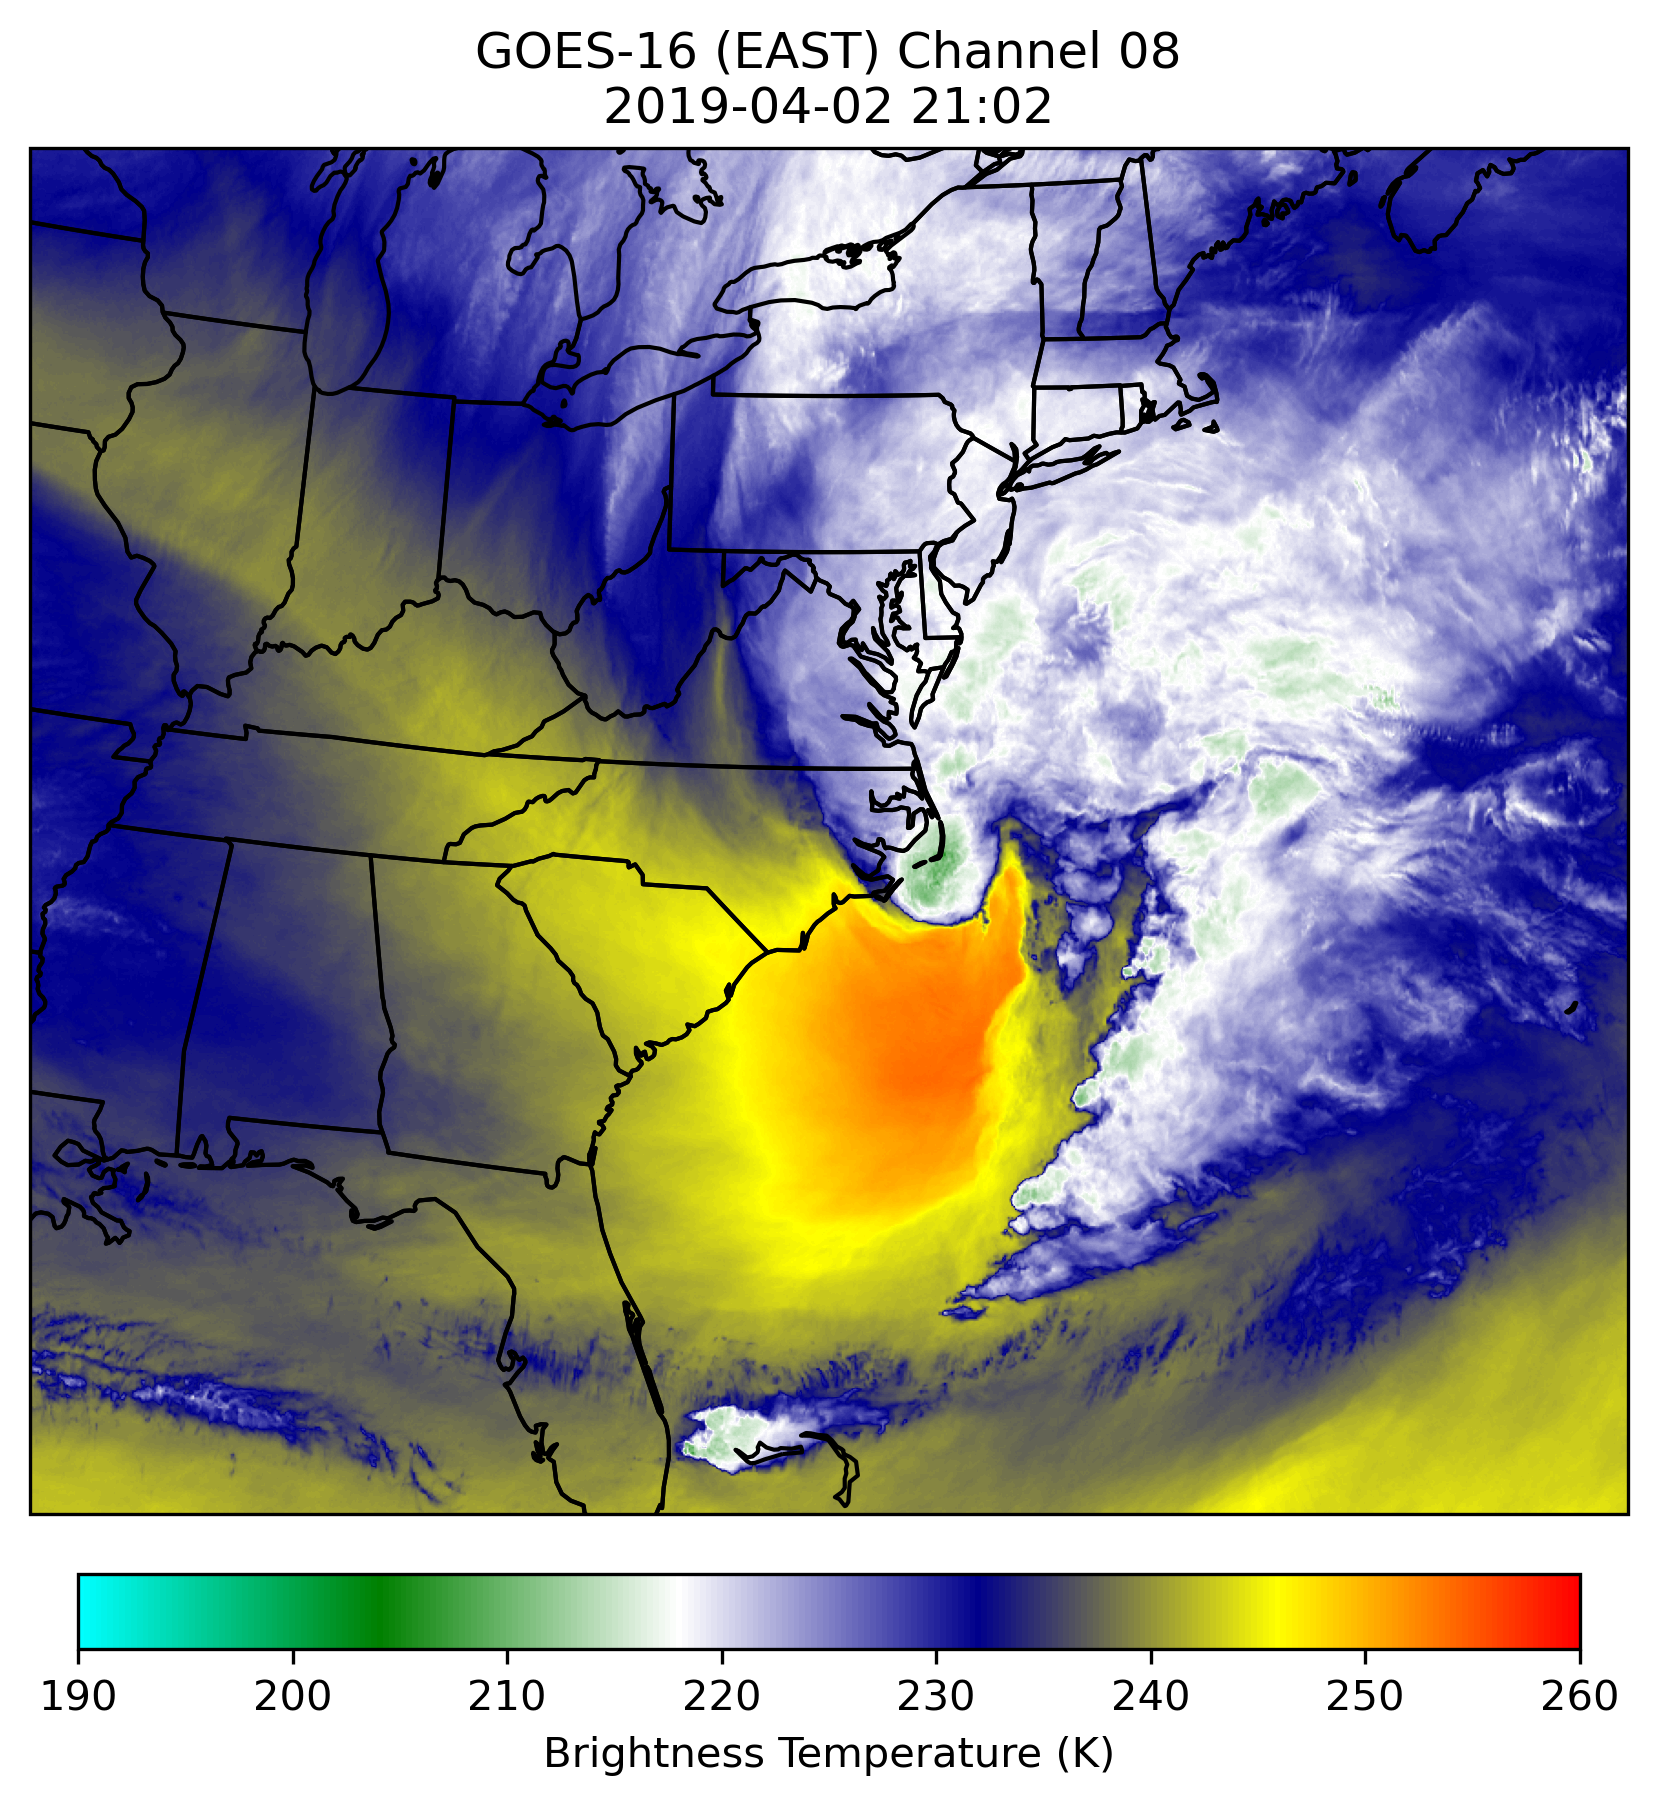

In [70]:
proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

fig=plt.figure(figsize=(11,6.5),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
#img = plt.imread('../basemaps/natural_earth.tif')
#img_extent = (-180,180,-90,90)
#ax.imshow(img,origin='upper',extent=img_extent,transform=ccrs.PlateCarree())
#ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
#ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

if int(channel) <= 6:
    img = ax.imshow(rad,vmin=(np.nanmin(rad)-0.1),vmax=np.nanmax(rad),origin='upper',extent=img_extent,cmap='Greys_r',transform=ccrs.Geostationary(lon,h))
    cb = plt.colorbar(img,orientation='horizontal',fraction=0.05,pad=0.04,label='Reflectivity')
elif int(channel) >= 8 and int(channel) <= 10:
    #create water vapor colormap
    norm = plt.Normalize(164,273)
    cmap = mcolors.LinearSegmentedColormap.from_list("",["cyan","green","white","darkblue","yellow","red"])
    #c1 = plt.cm.GnBu(np.arange(0,256,1))
    #c2 = plt.cm.RdYlBu_r(np.arange(0,128,1))
    #colors = np.vstack((c1, c2))
    #mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    img = ax.imshow(rad,origin='upper',extent=img_extent,cmap=cmap,transform=ccrs.Geostationary(lon,h),vmin=190,vmax=260)
    cb = plt.colorbar(img,orientation='horizontal',fraction=0.05,pad=0.04,label='Brightness Temperature (K)')
else:
    c1 = plt.cm.gist_rainbow(np.arange(0,256,1))
    c2 = plt.cm.gist_gray_r(np.arange(0,256,1))
    colors = np.vstack((c1, c2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    img = ax.imshow(rad,vmin=160,vmax=300,origin='upper',extent=img_extent,cmap=mymap,transform=ccrs.Geostationary(lon,h))
    cb = plt.colorbar(img,orientation='horizontal',fraction=0.05,pad=0.04,label='Brightness Temperature')
ax.set_extent((lon_min,lon_max,lat_min,lat_max))


plt.title('%s Channel %s\n'%(string,channel) + r'%s'%(img_time.strftime('%Y-%m-%d %H:%M')))
time_str = img_time.strftime('%Y%m%d_%H%M')
plt.savefig(f'GOES_CH{channel}_{time_str}.png')